# 数据处理
数据处理包含五个部分：数据导入、数据形状变换、数据集划分、数据归一化处理和封装load data函数。数据预处理后，才能被模型调用。

## 读入数据
通过如下代码读入数据，了解下波士顿房价的数据集结构，数据存放在本地目录下housing.data文件中。

数据集下载链接：
http://paddlemodels.bj.bcebos.com/uci_housing/housing.data

In [12]:
# 导入需要用到的package
import numpy as np
import json
# 读入训练数据
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ')
print(data)

[6.320e-03 1.800e+01 2.310e+00 ... 3.969e+02 7.880e+00 1.190e+01]


## 数据形状变换
由于读入的原始数据是1维的，所有数据都连在一起。因此需要我们将数据的形状进行变换，形成一个2维的矩阵，每行为一个数据样本（14个值），每个数据样本包含13个X（影响房价的特征）和一个Y（该类型房屋的均价）。

In [13]:
# 读入之后的数据被转化成1维array，其中array的第0-13项是第一条数据，第14-27项是第二条数据，以此类推.... 
# 这里对原始数据做reshape，变成N x 14的形式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num]) # reshape(列的长度，行的长度)
'''
 / 为浮点数除法，返回浮点结果

// 表示整数除法，返回不大于结果的一个最大整数
'''

# 查看数据
x = data[0]
print(x.shape)
print(x)

(14,)
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00 2.400e+01]


numpy的 reshape 函数尝试，一维array变换成为多维array

In [9]:
# 经过实验尝试，reshape(x, y)     x*y必须刚好满足之前一维的总数，多和少都不行
a = [1,2,3,4,5,6]
a_arr = np.array(a)
a_re = a_arr.reshape(2, 3)
print(a_re)

[[1 2 3]
 [4 5 6]]


## 数据集划分
在本案例中，我们将80%的数据用作训练集，20%用作测试集，实现代码如下。通过打印训练集的形状，可以发现共有404个样本，每个样本含有13个特征和1个预测值。

In [14]:
ratio = 0.8 # 划分训练集的比例
offset = int(data.shape[0] * ratio)
training_data = data[:offset]

print(training_data.shape)

(404, 14)


## 数据归一化处理
对每个特征进行归一化处理，使得每个特征的取值缩放到0~1之间。这样做有两个好处：一是模型训练更高效；二是特征前的权重大小可以代表该变量对预测结果的贡献度（因为每个特征值本身的范围相同）。

In [15]:
# 计算train数据集的最大值，最小值，平均值
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]

# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

归一化处理的尝试

In [23]:
a = [10,2,320,40,10,60]
a_arr = np.array(a)
a_re = a_arr.reshape(2, 3)


# 当axis=0时表示取每一列的最大值
# 当axis=1时表示取每一行的最大值
maximums, minimums, avgs = \
                     a_re.max(axis=0), \
                     a_re.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]

print(maximums)
print(minimums)
print(avgs)

for i in range(3):
    #print(maximums[i], minimums[i], avgs[i])
    a_re[:, i] = (a_re[:, i] - minimums[i]) / (maximums[i] - minimums[i])  # 所有行的第i列都在计算归一化之后的值
    
print(a_re)

[ 40  10 320]
[10  2 60]
[0.02146321 0.14232673 0.35896494 0.08663366 0.30191755 0.5311571
 0.63365062 0.27686108 0.25172191 0.34636929 0.57725932 0.9480888
 0.26558914 0.42612761]
[[0 0 1]
 [1 1 0]]


## 封装成load data函数
将上述几个数据处理操作封装成load data函数，以便下一步模型的调用，实现方法如下。

In [24]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [25]:
# 获取数据
training_data, test_data = load_data()
x = training_data[:, :-1]
y = training_data[:, -1:]

# 查看数据
print(x[0])
print(y[0])

[0.         0.18       0.07344184 0.         0.31481481 0.57750527
 0.64160659 0.26920314 0.         0.22755741 0.28723404 1.
 0.08967991]
[0.42222222]


# 模型设计
模型设计是深度学习模型关键要素之一，也称为网络结构设计，相当于模型的假设空间，即实现模型“前向计算”（从输入到输出）的过程。

如果将输入特征和输出预测值均以向量表示，输入特征xxx有13个分量，yyy有1个分量，那么参数权重的形状（shape）是13×113\times113×1。假设我们以如下任意数字赋值参数做初始化：

In [26]:
w = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, -0.1, -0.2, -0.3, -0.4, 0.0]
w = np.array(w).reshape([13, 1])

取出第1条样本数据，观察样本的特征向量与参数向量相乘的结果。

In [27]:
x1=x[0]
t = np.dot(x1, w)
print(t)

[0.69474855]


完整的线性回归公式，还需要初始化偏移量b，同样随意赋初值-0.2。那么，线性回归模型的完整输出是

$$z=t+b$$

这个从特征和参数计算输出值的过程称为“前向计算”。

In [28]:
b = -0.2
z = t + b
print(z)

[0.49474855]


将上述计算预测输出的过程以“类和对象”的方式来描述，类成员变量有参数www和bbb。通过写一个forward函数（代表“前向计算”）完成上述从特征和参数到输出预测值的计算过程，代码如下所示。

In [29]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，
        # 此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z

基于Network类的定义，模型的计算过程如下所示。

In [30]:
net = Network(13)
x1 = x[0]
y1 = y[0]
z = net.forward(x1)
print(z)

[2.39362982]


# 训练配置
模型设计完成后，需要通过训练配置寻找模型的最优值，即通过损失函数来衡量模型的好坏。训练配置也是深度学习模型关键要素之一。

通过模型计算$x_1$表示的影响因素所对应的房价应该是$z$, 但实际数据告诉我们房价是$y$。这时我们需要有某种指标来衡量预测值$z$跟真实值$y$之间的差距。对于回归问题，最常采用的衡量方法是使用均方误差作为评价模型好坏的指标，具体定义如下：

$$Loss = (y - z)^2$$

 

上式中的$Loss$（简记为: $L$）通常也被称作损失函数，它是衡量模型好坏的指标。在回归问题中，均方误差是一种比较常见的形式，分类问题中通常会采用交叉熵作为损失函数，在后续的章节中会更详细的介绍。对一个样本计算损失函数值的实现如下：

In [31]:
Loss = (y1 - z)*(y1 - z)
print(Loss)

[3.88644793]


因为计算损失函数时需要把每个样本的损失函数值都考虑到，所以我们需要对单个样本的损失函数进行求和，并除以样本总数$N$。

$$Loss= \frac{1}{N}\sum_{i=1}^N{(y_i - z_i)^2}$$


在Network类下面添加损失函数的计算过程如下：

In [33]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost

使用定义的Network类，可以方便的计算预测值和损失函数。需要注意的是，类中的变量$x$, $w$，$b$, $z$, $error$等均是向量。以变量$x$为例，共有两个维度，一个代表特征数量（值为13），一个代表样本数量，代码如下所示。

In [34]:
net = Network(13)
# 此处可以一次性计算多个样本的预测值和损失函数
x1 = x[0:3]
y1 = y[0:3]
z = net.forward(x1)
print('predict: ', z)
loss = net.loss(z, y1)
print('loss:', loss)

predict:  [[2.39362982]
 [2.46752393]
 [2.02483479]]
loss: 3.384496992612791


# 训练过程
上述计算过程描述了如何构建神经网络，通过神经网络完成预测值和损失函数的计算。接下来介绍如何求解参数$w$和$b$的数值，这个过程也称为模型训练过程。训练过程是深度学习模型的关键要素之一，其目标是让定义的损失函数$Loss$尽可能的小，也就是说找到一个参数解$w$和$b$，使得损失函数取得极小值。

## 梯度下降法
在现实中存在大量的函数正向求解容易，但反向求解较难，被称为单向函数，这种函数在密码学中有大量的应用。密码锁的特点是可以迅速判断一个密钥是否是正确的(已知xxx，求yyy很容易)，但是即使获取到密码锁系统，无法破解出正确的密钥是什么（已知$y$，求$x$很难）。

这种情况特别类似于一位想从山峰走到坡谷的盲人，他看不见坡谷在哪（无法逆向求解出$Loss$导数为0时的参数值），但可以伸脚探索身边的坡度（当前点的导数值，也称为梯度）。那么，求解$Loss$函数最小值可以这样实现：从当前的参数取值，一步步的按照下坡的方向下降，直到走到最低点。这种方法笔者称它为“盲人下坡法”。哦不，有个更正式的说法“梯度下降法”。

训练的关键是找到一组$(w, b)$，使得损失函数$L$取极小值。我们先看一下损失函数$L$只随两个参数$w_5$、$w_9$变化时的简单情形，启发下寻解的思路。

$$L=L(w_5, w_9)$$

这里我们将$w_0,w_1, ..., w_{12}$中除$w_5,w_9$之外的参数和$b$都固定下来，可以用图画出$)L(w_5, w_9)$的形式。

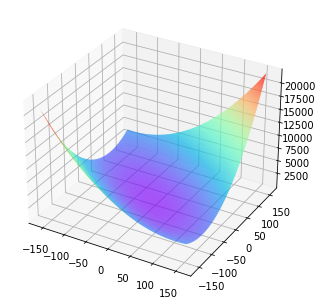

In [36]:
net = Network(13)
losses = []
#只画出参数w5和w9在区间[-160, 160]的曲线部分，以及包含损失函数的极值
w5 = np.arange(-160.0, 160.0, 1.0)
w9 = np.arange(-160.0, 160.0, 1.0)
losses = np.zeros([len(w5), len(w9)])

#计算设定区域内每个参数取值所对应的Loss
for i in range(len(w5)):
    for j in range(len(w9)):
        net.w[5] = w5[i]
        net.w[9] = w9[j]
        z = net.forward(x)
        loss = net.loss(z, y)
        losses[i, j] = loss

#使用matplotlib将两个变量和对应的Loss作3D图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

w5, w9 = np.meshgrid(w5, w9)

ax.plot_surface(w5, w9, losses, rstride=1, cstride=1, cmap='rainbow')
plt.show()

对于这种简单情形，我们利用上面的程序，可以在三维空间中画出损失函数随参数变化的曲面图。从图中可以看出有些区域的函数值明显比周围的点小。

需要说明的是：为什么这里我们选择$w_5$和$w_9$来画图？这是因为选择这两个参数的时候，可比较直观的从损失函数的曲面图上发现极值点的存在。其他参数组合，从图形上观测损失函数的极值点不够直观。

### 误差为什么要选均方误差
均方误差表现的“圆滑”的坡度有两个好处：

曲线的最低点是可导的。
越接近最低点，曲线的坡度逐渐放缓，有助于通过当前的梯度来判断接近最低点的程度（是否逐渐减少步长，以免错过最低点）。

而绝对值误差是不具备这两个特性的，这也是损失函数的设计不仅仅要考虑“合理性”，还要追求“易解性”的原因。

现在我们要找出一组$[w_5, w_9]$的值，使得损失函数最小，实现梯度下降法的方案如下：

步骤1：随机的选一组初始值，例如：$[w_5, w_9] = [-100.0, -100.0]$

步骤2：选取下一个点$[w_5^{'} , w_9^{'}]$，使得$L(w_5^{'} , w_9^{'}) < L(w_5, w_9)$

步骤3：重复步骤2，直到损失函数几乎不再下降。

如何选择$[w_5^{'} , w_9^{'}]$是至关重要的，第一要保证$L$是下降的，第二要使得下降的趋势尽可能的快。微积分的基础知识告诉我们，沿着梯度的反方向，是函数值下降最快的方向

## 计算梯度
上面我们讲过了损失函数的计算方法，这里稍微改写，为了使梯度计算更加简洁，引入因子$\frac{1}{2}$，定义损失函数如下：

$$L= \frac{1}{2N}\sum_{i=1}^N{(y_i - z_i)^2}$$

其中$z_i$是网络对第$i$个样本的预测值：

$$z_i = \sum_{j=0}^{12}{x_i^{j}\cdot w_j} + b$$

梯度的定义：

$$𝑔𝑟𝑎𝑑𝑖𝑒𝑛𝑡 = (\frac{\partial{L}}{\partial{w_0}},\frac{\partial{L}}{\partial{w_1}}, ... ,\frac{\partial{L}}{\partial{w_{12}}} ,\frac{\partial{L}}{\partial{b}})$$

可以计算出$L$对$w$和$b$的偏导数：

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{w_j}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)x_i^{j}}$$

$$\frac{\partial{L}}{\partial{b}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{b}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)}$$

从导数的计算过程可以看出，因子$\frac{1}{2}$被消掉了，这是因为二次函数求导的时候会产生因子$2$，这也是我们将损失函数改写的原因。

下面我们考虑只有一个样本的情况下，计算梯度：

$$L= \frac{1}{2}{(y_i - z_i)^2}$$

$$z_1 = {x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ... + {x_1^{12}\cdot w_{12}} + b$$

可以计算出：

$$L= \frac{1}{2}{({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ... + {x_1^{12}\cdot w_{12}} + b - y_1)^2}$$

可以计算出LLL对www和bbb的偏导数：

$$\frac{\partial{L}}{\partial{w_0}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ... + {x_1^{12}\cdot w_12} + b - y_1)\cdot x_1^{0}=({z_1} - {y_1})\cdot x_1^{0}$$

$$\frac{\partial{L}}{\partial{b}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ... + {x_1^{12}\cdot w_{12}} + b - y_1)\cdot 1 = ({z_1} - {y_1})$$

可以通过具体的程序查看每个变量的数据和维度。

In [37]:
x1 = x[0]
y1 = y[0]
z1 = net.forward(x1)
print('x1 {}, shape {}'.format(x1, x1.shape))
print('y1 {}, shape {}'.format(y1, y1.shape))
print('z1 {}, shape {}'.format(z1, z1.shape))

x1 [0.         0.18       0.07344184 0.         0.31481481 0.57750527
 0.64160659 0.26920314 0.         0.22755741 0.28723404 1.
 0.08967991], shape (13,)
y1 [0.42222222], shape (1,)
z1 [130.86954441], shape (1,)


In [38]:
gradient_w0 = (z1 - y1) * x1[0]
print('gradient_w0 {}'.format(gradient_w0))

gradient_w0 [0.]


In [39]:
gradient_w1 = (z1 - y1) * x1[1]
print('gradient_w1 {}'.format(gradient_w1))

gradient_w1 [23.48051799]


In [40]:
gradient_w2= (z1 - y1) * x1[2]
print('gradient_w1 {}'.format(gradient_w2))

gradient_w1 [9.58029163]


聪明的读者可能已经想到，写一个for循环即可计算从$w_0$到$w_{12}$的所有权重的梯度，该方法读者可以自行实现

## 使用Numpy进行梯度计算
基于Numpy广播机制（对向量和矩阵计算如同对1个单一变量计算一样），可以更快速的实现梯度计算。计算梯度的代码中直接用$(z_1 - y_1) \cdot x_1$，得到的是一个13维的向量，每个分量分别代表该维度的梯度

In [41]:
gradient_w = (z1 - y1) * x1
print('gradient_w_by_sample1 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample1 [  0.          23.48051799   9.58029163   0.          41.06674958
  75.33401592  83.69586171  35.11682862   0.          29.68425495
  37.46891169 130.44732219  11.69850434], gradient.shape (13,)


输入数据中有多个样本，每个样本都对梯度有贡献。如上代码计算了只有样本1时的梯度值，同样的计算方法也可以计算样本2和样本3对梯度的贡献。

In [42]:
x2 = x[1]
y2 = y[1]
z2 = net.forward(x2)
gradient_w = (z2 - y2) * x2
print('gradient_w_by_sample2 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample2 [2.54738434e-02 0.00000000e+00 2.83333765e+01 0.00000000e+00
 1.86624242e+01 5.91703008e+01 8.45121992e+01 3.76793284e+01
 4.69458498e+00 1.23980167e+01 5.97311025e+01 1.07975454e+02
 2.20777626e+01], gradient.shape (13,)


In [43]:
x3 = x[2]
y3 = y[2]
z3 = net.forward(x3)
gradient_w = (z3 - y3) * x3
print('gradient_w_by_sample3 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample3 [3.07963708e-02 0.00000000e+00 3.42860463e+01 0.00000000e+00
 2.25832858e+01 9.07287666e+01 7.83155260e+01 4.55955257e+01
 5.68088867e+00 1.50027645e+01 7.22802431e+01 1.29029688e+02
 8.29246719e+00], gradient.shape (13,)


可能有的读者再次想到可以使用for循环把每个样本对梯度的贡献都计算出来，然后再作平均。但是我们不需要这么做，仍然可以使用Numpy的矩阵操作来简化运算，如3个样本的情况。

In [44]:
# 注意这里是一次取出3个样本的数据，不是取出第3个样本
x3samples = x[0:3]
y3samples = y[0:3]
z3samples = net.forward(x3samples)

print('x {}, shape {}'.format(x3samples, x3samples.shape))
print('y {}, shape {}'.format(y3samples, y3samples.shape))
print('z {}, shape {}'.format(z3samples, z3samples.shape))

x [[0.00000000e+00 1.80000000e-01 7.34418420e-02 0.00000000e+00
  3.14814815e-01 5.77505269e-01 6.41606591e-01 2.69203139e-01
  0.00000000e+00 2.27557411e-01 2.87234043e-01 1.00000000e+00
  8.96799117e-02]
 [2.35922539e-04 0.00000000e+00 2.62405717e-01 0.00000000e+00
  1.72839506e-01 5.47997701e-01 7.82698249e-01 3.48961980e-01
  4.34782609e-02 1.14822547e-01 5.53191489e-01 1.00000000e+00
  2.04470199e-01]
 [2.35697744e-04 0.00000000e+00 2.62405717e-01 0.00000000e+00
  1.72839506e-01 6.94385898e-01 5.99382080e-01 3.48961980e-01
  4.34782609e-02 1.14822547e-01 5.53191489e-01 9.87519166e-01
  6.34657837e-02]], shape (3, 13)
y [[0.42222222]
 [0.36888889]
 [0.66      ]], shape (3, 1)
z [[130.86954441]
 [108.34434338]
 [131.3204395 ]], shape (3, 1)


上面的x3samples, y3samples, z3samples的第一维大小均为3，表示有3个样本。下面计算这3个样本对梯度的贡献。

In [45]:
gradient_w = (z3samples - y3samples) * x3samples
print('gradient_w {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w [[0.00000000e+00 2.34805180e+01 9.58029163e+00 0.00000000e+00
  4.10667496e+01 7.53340159e+01 8.36958617e+01 3.51168286e+01
  0.00000000e+00 2.96842549e+01 3.74689117e+01 1.30447322e+02
  1.16985043e+01]
 [2.54738434e-02 0.00000000e+00 2.83333765e+01 0.00000000e+00
  1.86624242e+01 5.91703008e+01 8.45121992e+01 3.76793284e+01
  4.69458498e+00 1.23980167e+01 5.97311025e+01 1.07975454e+02
  2.20777626e+01]
 [3.07963708e-02 0.00000000e+00 3.42860463e+01 0.00000000e+00
  2.25832858e+01 9.07287666e+01 7.83155260e+01 4.55955257e+01
  5.68088867e+00 1.50027645e+01 7.22802431e+01 1.29029688e+02
  8.29246719e+00]], gradient.shape (3, 13)


此处可见，计算梯度`gradient_w`的维度是$3×13$，并且其第1行与上面第1个样本计算的梯度gradient_w_by_sample1一致，第2行与上面第2个样本计算的梯度gradient_w_by_sample2一致，第3行与上面第3个样本计算的梯度gradient_w_by_sample3一致。这里使用矩阵操作，可以更加方便的对3个样本分别计算各自对梯度的贡献。

那么对于有N个样本的情形，我们可以直接使用如下方式计算出所有样本对梯度的贡献，这就是使用Numpy库广播功能带来的便捷。 小结一下这里使用Numpy库的广播功能：

一方面可以扩展参数的维度，代替for循环来计算1个样本对从$w_0$到$w_{12}$的所有参数的梯度。
另一方面可以扩展样本的维度，代替for循环来计算样本0到样本403对参数的梯度。

In [46]:
z = net.forward(x)
gradient_w = (z - y) * x
print('gradient_w shape {}'.format(gradient_w.shape))
print(gradient_w)

gradient_w shape (404, 13)
[[0.00000000e+00 2.34805180e+01 9.58029163e+00 ... 3.74689117e+01
  1.30447322e+02 1.16985043e+01]
 [2.54738434e-02 0.00000000e+00 2.83333765e+01 ... 5.97311025e+01
  1.07975454e+02 2.20777626e+01]
 [3.07963708e-02 0.00000000e+00 3.42860463e+01 ... 7.22802431e+01
  1.29029688e+02 8.29246719e+00]
 ...
 [3.97706874e+01 0.00000000e+00 1.74130673e+02 ... 2.01043762e+02
  2.48659390e+02 1.27554582e+02]
 [2.69696515e+01 0.00000000e+00 1.75225687e+02 ... 2.02308019e+02
  2.34270491e+02 1.28287658e+02]
 [6.08972123e+01 0.00000000e+00 1.53017134e+02 ... 1.76666981e+02
  2.18509161e+02 1.08772220e+02]]


上面gradient_w的每一行代表了一个样本对梯度的贡献。根据梯度的计算公式，总梯度是对每个样本对梯度贡献的平均值。

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{w_j}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)x_i^{j}}$$

我们也可以使用Numpy的均值函数来完成此过程：

In [47]:
# 用均值来做更新
# axis = 0 表示把每一行做相加然后再除以总的行数
gradient_w = np.mean(gradient_w, axis=0)
print('gradient_w ', gradient_w.shape)
print('w ', net.w.shape)
print(gradient_w)
print(net.w)

gradient_w  (13,)
w  (13, 1)
[  4.6555403   19.35268996  55.88081118  14.00266972  47.98588869
  76.87210821  94.8555119   36.07579608  45.44575958  59.65733292
  83.65114918 134.80387478  38.93998153]
[[ 1.76405235e+00]
 [ 4.00157208e-01]
 [ 9.78737984e-01]
 [ 2.24089320e+00]
 [ 1.86755799e+00]
 [ 1.59000000e+02]
 [ 9.50088418e-01]
 [-1.51357208e-01]
 [-1.03218852e-01]
 [ 1.59000000e+02]
 [ 1.44043571e-01]
 [ 1.45427351e+00]
 [ 7.61037725e-01]]


我们使用Numpy的矩阵操作方便地完成了gradient的计算，但引入了一个问题，gradient_w的形状是(13,)，而w的维度是(13, 1)。导致该问题的原因是使用np.mean函数时消除了第0维。为了加减乘除等计算方便，gradient_w和w必须保持一致的形状。因此我们将gradient_w的维度也设置为(13,1)，代码如下：

In [48]:
gradient_w = gradient_w[:, np.newaxis] # 加一个新的维度，这个维度是虚的，实际上并没有加
print('gradient_w shape', gradient_w.shape)

gradient_w shape (13, 1)


In [49]:
z = net.forward(x)
gradient_w = (z - y) * x
gradient_w = np.mean(gradient_w, axis=0)
gradient_w = gradient_w[:, np.newaxis]
print(gradient_w)

[[  4.6555403 ]
 [ 19.35268996]
 [ 55.88081118]
 [ 14.00266972]
 [ 47.98588869]
 [ 76.87210821]
 [ 94.8555119 ]
 [ 36.07579608]
 [ 45.44575958]
 [ 59.65733292]
 [ 83.65114918]
 [134.80387478]
 [ 38.93998153]]


上述代码非常简洁地完成了w的梯度计算。同样，计算b的梯度的代码也是类似的原理。

In [51]:
gradient_b = (z - y)
gradient_b = np.mean(gradient_b)
# 此处b是一个数值，所以可以直接用np.mean得到一个标量
print(gradient_b)

142.50289323156107


将上面计算w和b的梯度的过程，写成Network类的gradient函数，实现方法如下所示。

In [52]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)
        
        return gradient_w, gradient_b

In [53]:
# 调用上面定义的gradient函数，计算梯度
# 初始化网络
net = Network(13)
# 设置[w5, w9] = [-100., -100.]
net.w[5] = -100.0
net.w[9] = -100.0

z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-100.0, -100.0], loss 7873.345739941161
gradient [-45.87968288123223, -35.50236884482904]


## 确定损失函数更小的点
下面我们开始研究更新梯度的方法。首先沿着梯度的反方向移动一小步，找到下一个点P1，观察损失函数的变化。

In [ ]:
# 在[w5, w9]平面上，沿着梯度的反方向移动到下一个点P1
# 定义移动步长 eta
eta = 0.1
# 更新参数w5和w9
net.w[5] = net.w[5] - eta * gradient_w5
net.w[9] = net.w[9] - eta * gradient_w9
# 重新计算z和loss
z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

运行上面的代码，可以发现沿着梯度反方向走一小步，下一个点的损失函数的确减少了。感兴趣的话，大家可以尝试不停的点击上面的代码块，观察损失函数是否一直在变小。

在上述代码中，每次更新参数使用的语句： `net.w[5] = net.w[5] - eta * gradient_w5`

- 相减：参数需要向梯度的反方向移动。
- eta：控制每次参数值沿着梯度反方向变动的大小，即每次移动的步长，又称为学习率。

## 代码封装Train函数
将上面的循环计算过程封装在train和update函数中，实现方法如下所示。

iter 0, point [-99.54120317118768, -99.64497631155172], loss 7873.345739941161
iter 50, point [-76.60136173057143, -83.72583210997178], loss 4968.072469025462
iter 100, point [-53.66152028995518, -71.17197938338234], loss 2879.1147724286443
iter 150, point [-30.72167884933894, -61.670172857784976], loss 1466.5327423342467
iter 200, point [-7.781837408722867, -54.93632449635134], loss 617.3700852775535
iter 250, point [15.158004031893235, -50.712789509620166], loss 240.66496301508988
iter 300, point [38.097845472509356, -48.76590498704591], loss 263.3649807616624
iter 350, point [61.037686913125604, -48.883757635606784], loss 626.9841087431722
iter 400, point [83.97752835374185, -50.87415929991915], loss 1284.86827670467
iter 450, point [106.9173697943581, -54.56281092331177], loss 2199.960180490574
iter 500, point [129.85721123497433, -59.791637409555065], loss 3342.9734013364086
iter 550, point [152.79705267559058, -66.41727747761158], loss 4690.90201557339
iter 600, point [175.736894

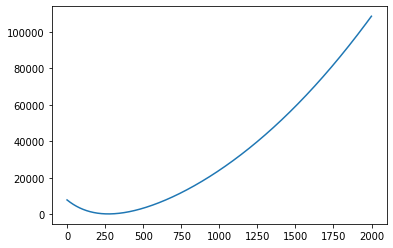

In [56]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights,1)
        self.w[5] = -100.
        self.w[9] = -100.
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, graident_w5, gradient_w9, eta=0.01):
        net.w[5] = net.w[5] - eta * gradient_w5
        net.w[9] = net.w[9] - eta * gradient_w9
        
    def train(self, x, y, iterations=100, eta=0.01):
        points = []
        losses = []
        for i in range(iterations):
            points.append([net.w[5][0], net.w[9][0]])
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            gradient_w5 = gradient_w[5][0]
            gradient_w9 = gradient_w[9][0]
            self.update(gradient_w5, gradient_w9, eta)
            losses.append(L)
            if i % 50 == 0:
                print('iter {}, point {}, loss {}'.format(i, [net.w[5][0], net.w[9][0]], L))
        return points, losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=2000
# 启动训练
points, losses = net.train(x, y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

训练扩展到全部参数
为了能给读者直观的感受，上面演示的梯度下降的过程仅包含$w_5$和$w_9$两个参数，但房价预测的完整模型，必须要对所有参数$w$和$b$进行求解。这需要将Network中的update和train函数进行修改。由于不再限定参与计算的参数（所有参数均参与计算），修改之后的代码反而更加简洁。实现逻辑：“前向计算输出、根据输出和真实值计算Loss、基于Loss和输入计算梯度、根据梯度更新参数值”四个部分反复执行，直到损失函数最小。具体代码如下所示。

iter 9, loss 5.143394325795511
iter 19, loss 3.097924194225988
iter 29, loss 2.082241020617026
iter 39, loss 1.5673801618157397
iter 49, loss 1.2966204735077431
iter 59, loss 1.1453399043319765
iter 69, loss 1.0530155717435201
iter 79, loss 0.9902292156463155
iter 89, loss 0.9426576903842504
iter 99, loss 0.9033048096880774
iter 109, loss 0.868732003041364
iter 119, loss 0.837229250968144
iter 129, loss 0.807927474161227
iter 139, loss 0.7803677341465797
iter 149, loss 0.7542920908532763
iter 159, loss 0.7295420168915829
iter 169, loss 0.7060090054240882
iter 179, loss 0.6836105084697767
iter 189, loss 0.6622781710179412
iter 199, loss 0.6419520361168637
iter 209, loss 0.622577651786949
iter 219, loss 0.6041045903195837
iter 229, loss 0.5864856570315078
iter 239, loss 0.5696764374763879
iter 249, loss 0.5536350125932015
iter 259, loss 0.5383217588525027
iter 269, loss 0.5236991929680567
iter 279, loss 0.509731841376165
iter 289, loss 0.4963861247069634
iter 299, loss 0.4836302523439023

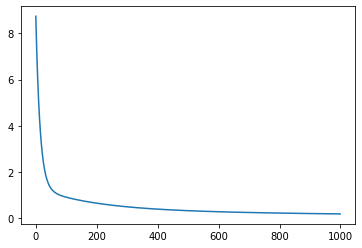

In [57]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, L))
        return losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

# 随机梯度下降法（ Stochastic Gradient Descent）
在上述程序中，每次损失函数和梯度计算都是基于数据集中的全量数据。对于波士顿房价预测任务数据集而言，样本数比较少，只有404个。但在实际问题中，数据集往往非常大，如果每次都使用全量数据进行计算，效率非常低，通俗地说就是“杀鸡焉用牛刀”。由于参数每次只沿着梯度反方向更新一点点，因此方向并不需要那么精确。一个合理的解决方案是每次从总的数据集中随机抽取出小部分数据来代表整体，基于这部分数据计算梯度和损失来更新参数，这种方法被称作随机梯度下降法（Stochastic Gradient Descent，SGD），核心概念如下：

- mini-batch：每次迭代时抽取出来的一批数据被称为一个mini-batch。
- batch_size：一个mini-batch所包含的样本数目称为batch_size。
- epoch：当程序迭代的时候，按mini-batch逐渐抽取出样本，当把整个数据集都遍历到了的时候，则完成了一轮训练，也叫一个epoch。启动训练时，可以将训练的轮数num_epochs和batch_size作为参数传入。

下面结合程序介绍具体的实现过程，涉及到数据处理和训练过程两部分代码的修改。

## 数据处理代码修改
数据处理需要实现拆分数据批次和样本乱序（为了实现随机抽样的效果）两个功能。

In [58]:
# 获取数据
train_data, test_data = load_data()
train_data.shape

(404, 14)

train_data中一共包含404条数据，如果batch_size=10，即取前0-9号样本作为第一个mini-batch，命名train_data1。

In [59]:
train_data1 = train_data[0:10]
print(train_data1.shape)

(10, 14)


使用train_data1的数据（0-9号样本）计算梯度并更新网络参数。

In [60]:
net = Network(13)
x = train_data1[:, :-1]
y = train_data1[:, -1:]
loss = net.train(x, y, iterations=1, eta=0.01)
print(loss)

[4.497480200683046]


再取出10-19号样本作为第二个mini-batch，计算梯度并更新网络参数。

In [62]:
train_data2 = train_data[10:20]
x = train_data2[:, :-1]
y = train_data2[:, -1:]
loss = net.train(x, y, iterations=1, eta=0.01)
print(loss)

[5.849682302465982]


按此方法不断的取出新的mini-batch，并逐渐更新网络参数。

接下来，将train_data分成大小为batch_size的多个mini_batch，如下代码所示：将train_data分成 $\frac{404}{10} + 1 = 41$个 mini_batch，其中前40个mini_batch，每个均含有10个样本，最后一个mini_batch只含有4个样本。

In [63]:
batch_size = 10
n = len(train_data)
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]
print('total number of mini_batches is ', len(mini_batches))
print('first mini_batch shape ', mini_batches[0].shape)
print('last mini_batch shape ', mini_batches[-1].shape)

total number of mini_batches is  41
first mini_batch shape  (10, 14)
last mini_batch shape  (4, 14)


另外，这里是按顺序读取mini_batch，而SGD里面是随机抽取一部分样本代表总体。为了实现随机抽样的效果，我们先将train_data里面的样本顺序随机打乱，然后再抽取mini_batch。随机打乱样本顺序，需要用到np.random.shuffle函数，下面先介绍它的用法。

说明：

通过大量实验发现，模型对最后出现的数据印象更加深刻。训练数据导入后，越接近模型训练结束，最后几个批次数据对模型参数的影响越大。为了避免模型记忆影响训练效果，需要进行样本乱序操作。


In [64]:
# 新建一个array
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
print('before shuffle', a)
np.random.shuffle(a)
print('after shuffle', a)

before shuffle [ 1  2  3  4  5  6  7  8  9 10 11 12]
after shuffle [ 7  2 11  3  8  6 12  1  4  5 10  9]


多次运行上面的代码，可以发现每次执行shuffle函数后的数字顺序均不同。 上面举的是一个1维数组乱序的案例，我们再观察下2维数组乱序后的效果。

In [65]:
# 新建一个array
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
a = a.reshape([6, 2])
print('before shuffle\n', a)
np.random.shuffle(a)
print('after shuffle\n', a)

before shuffle
 [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
after shuffle
 [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 9 10]
 [11 12]
 [ 7  8]]


观察运行结果可发现，数组的元素在第0维被随机打乱，但第1维的顺序保持不变。例如数字2仍然紧挨在数字1的后面，数字8仍然紧挨在数字7的后面，而第二维的[3, 4]并不排在[1, 2]的后面。将这部分实现SGD算法的代码集成到Network类中的train函数中，最终的完整代码如下。

In [66]:
# 获取数据
train_data, test_data = load_data()

# 打乱样本顺序
np.random.shuffle(train_data)

# 将train_data分成多个mini_batch
batch_size = 10
n = len(train_data)
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]

# 创建网络
net = Network(13)

# 依次使用每个mini_batch的数据
for mini_batch in mini_batches:
    x = mini_batch[:, :-1]
    y = mini_batch[:, -1:]
    loss = net.train(x, y, iterations=1)

## 训练过程代码修改
将每个随机抽取的mini-batch数据输入到模型中用于参数训练。训练过程的核心是两层循环：

第一层循环，代表样本集合要被训练遍历几次，称为“epoch”，代码如下：
`for epoch_id in range(num_epochs):`

第二层循环，代表每次遍历时，样本集合被拆分成的多个批次，需要全部执行训练，称为“iter (iteration)”，代码如下：
`for iter_id,mini_batch in emumerate(mini_batches):`

在两层循环的内部是经典的四步训练流程：前向计算->计算损失->计算梯度->更新参数，这与大家之前所学是一致的，代码如下：

In [ ]:
x = mini_batch[:, :-1]
y = mini_batch[:, -1:]
a = self.forward(x)  #前向计算
loss = self.loss(a, y)  #计算损失
gradient_w, gradient_b = self.gradient(x, y)  #计算梯度
self.update(gradient_w, gradient_b, eta)  #更新参数

将两部分改写的代码集成到Network类中的train函数中，最终的实现如下。

Epoch   0 / iter   0, loss = 1.1717
Epoch   0 / iter   1, loss = 1.1861
Epoch   0 / iter   2, loss = 0.7858
Epoch   0 / iter   3, loss = 0.7090
Epoch   0 / iter   4, loss = 0.9849
Epoch   0 / iter   5, loss = 0.9645
Epoch   0 / iter   6, loss = 0.8700
Epoch   0 / iter   7, loss = 1.0085
Epoch   0 / iter   8, loss = 0.0471
Epoch   1 / iter   0, loss = 0.9348
Epoch   1 / iter   1, loss = 1.0426
Epoch   1 / iter   2, loss = 0.7561
Epoch   1 / iter   3, loss = 0.7675
Epoch   1 / iter   4, loss = 0.8446
Epoch   1 / iter   5, loss = 0.7855
Epoch   1 / iter   6, loss = 0.5978
Epoch   1 / iter   7, loss = 0.7198
Epoch   1 / iter   8, loss = 1.3428
Epoch   2 / iter   0, loss = 0.7804
Epoch   2 / iter   1, loss = 0.9117
Epoch   2 / iter   2, loss = 0.8047
Epoch   2 / iter   3, loss = 0.7076
Epoch   2 / iter   4, loss = 0.9111
Epoch   2 / iter   5, loss = 0.3512
Epoch   2 / iter   6, loss = 0.5853
Epoch   2 / iter   7, loss = 0.6194
Epoch   2 / iter   8, loss = 0.6099
Epoch   3 / iter   0, loss =

Epoch  40 / iter   0, loss = 0.1374
Epoch  40 / iter   1, loss = 0.1643
Epoch  40 / iter   2, loss = 0.1168
Epoch  40 / iter   3, loss = 0.1384
Epoch  40 / iter   4, loss = 0.0913
Epoch  40 / iter   5, loss = 0.1814
Epoch  40 / iter   6, loss = 0.1157
Epoch  40 / iter   7, loss = 0.1272
Epoch  40 / iter   8, loss = 0.0458
Epoch  41 / iter   0, loss = 0.1056
Epoch  41 / iter   1, loss = 0.1545
Epoch  41 / iter   2, loss = 0.1080
Epoch  41 / iter   3, loss = 0.1118
Epoch  41 / iter   4, loss = 0.1462
Epoch  41 / iter   5, loss = 0.1590
Epoch  41 / iter   6, loss = 0.1412
Epoch  41 / iter   7, loss = 0.1187
Epoch  41 / iter   8, loss = 0.1468
Epoch  42 / iter   0, loss = 0.1463
Epoch  42 / iter   1, loss = 0.1510
Epoch  42 / iter   2, loss = 0.1168
Epoch  42 / iter   3, loss = 0.1195
Epoch  42 / iter   4, loss = 0.1294
Epoch  42 / iter   5, loss = 0.1280
Epoch  42 / iter   6, loss = 0.1575
Epoch  42 / iter   7, loss = 0.0852
Epoch  42 / iter   8, loss = 0.0233
Epoch  43 / iter   0, loss =

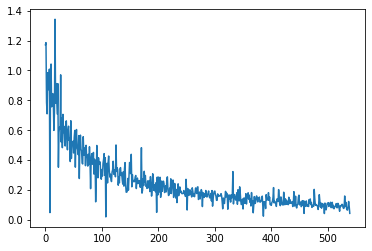

In [68]:
import numpy as np

class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        #np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = 1. / N * np.sum((z-y) * x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = 1. / N * np.sum(z-y)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

# 获取数据
train_data, test_data = load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=60, batch_size=50, eta=0.05)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

观察上述Loss的变化，随机梯度下降加快了训练过程，但由于每次仅基于少量样本更新参数和计算损失，所以损失下降曲线会出现震荡。

说明：
由于房价预测的数据量过少，所以难以感受到随机梯度下降带来的性能提升。

# 总结
本节我们详细介绍了如何使用Numpy实现梯度下降算法，构建并训练了一个简单的线性模型实现波士顿房价预测，可以总结出，使用神经网络建模房价预测有三个要点：

- 构建网络，初始化参数www和bbb，定义预测和损失函数的计算方法。
- 随机选择初始点，建立梯度的计算方法和参数更新方式。
- 从总的数据集中抽取部分数据作为一个mini_batch，计算梯度并更新参数，不断迭代直到损失函数几乎不再下降。


总共是一个循环往复的四步：
- 前向计算拿到我们预测的输出
- 通过输出与真实的y值，计算出Loss
- 通过前两步计算梯度
- 通过梯度，更新参数值